<Axes: >

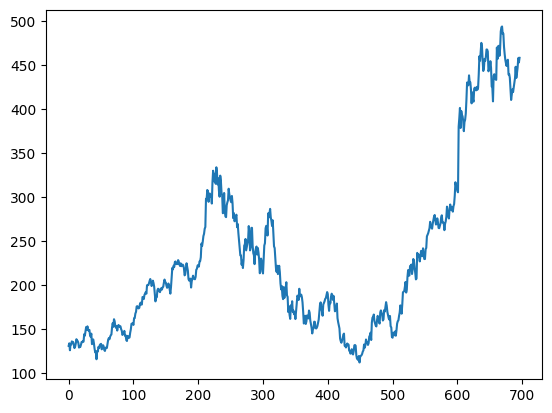

In [3]:
import pandas as pd
df = pd.read_csv('data.csv')
#df.info()
df["Close"].plot()

In [4]:
msk = (df.index < len(df)-30)
df_train = df[msk].copy()
df_test = df[~msk].copy()

p-value: 0.9759879740013196


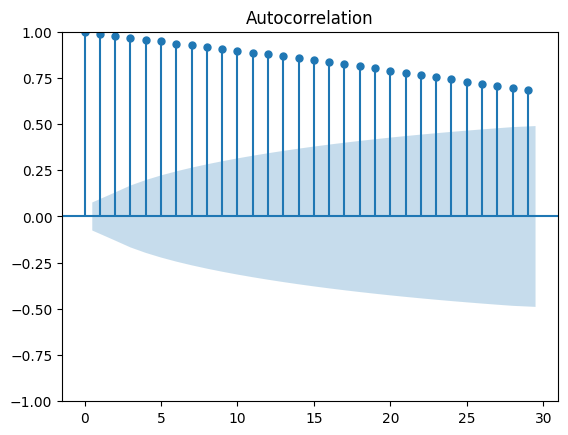

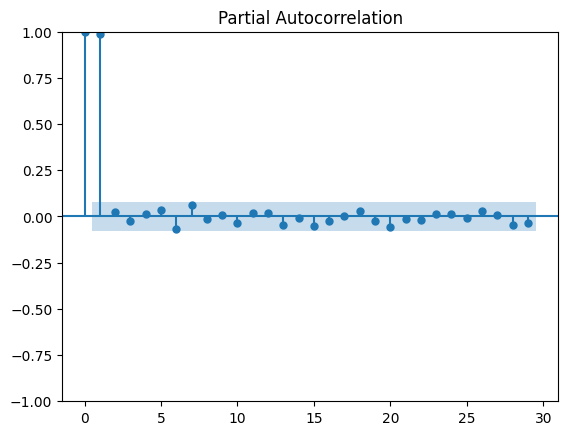

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(df_train["Close"])
pacf_original = plot_pacf(df_train["Close"])
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_train["Close"])
print(f'p-value: {adf_test[1]}')

<Axes: >

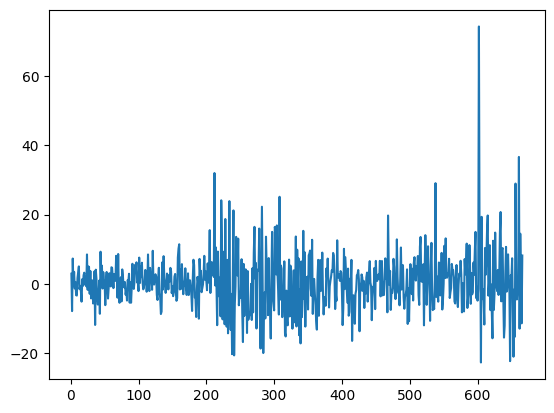

In [23]:
df_train_diff = df_train["Close"].diff().dropna()
df_train_diff.plot()


In [48]:
from statsmodels.tsa.arima.model import ARIMA
import itertools
p = d = q = range(1,5)
pdq = list(itertools.product(p,d,q))
for param in pdq:
    try: 
        model = ARIMA(df_train["Close"].reset_index(), order=param)
        model_fit = model.fit()
        print(param, model_fit.aic())
    except:
        continue

In [46]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_train["Close"], order=(0,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  667
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2335.285
Date:                Sun, 15 Oct 2023   AIC                           4672.569
Time:                        13:21:32   BIC                           4677.070
Sample:                             0   HQIC                          4674.313
                                - 667                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        65.0416      1.355     48.018      0.000      62.387      67.696
Ljung-Box (L1) (Q):                   0.41   Jarque-Bera (JB):              3960.74
Prob(Q):                              0.52   Pr

<Axes: >

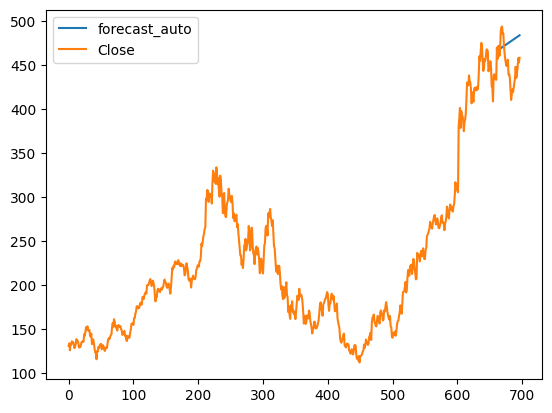

In [45]:
forecast_test_auto = auto_arima.predict(n_periods=len(df_test["Close"]))
df['forecast_auto'] = [None]*len(df_train["Close"]) + list(forecast_test_auto)

df[['forecast_auto', 'Close']].plot()